# AI Lab 2: Tree search algorithms (BFS and DFS)

In [1]:
# Mounting the Google Drive folder (run if necessary)
from google.colab import drive
drive.mount('/content/drive/')
# Saving the present working directory's path
pwd = "/content/drive/MyDrive/ColabNotebooks/AI-Labs/AI-Lab2-UninformedTreeSearch/" # Present working directory

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In this lab, we are going to implement and compare two of our basic search algorithms, namely Breadth First Search (**BFS**) and Depth First Search (**DFS**) on a real-world problem. For a quick tutorial on graph visualisation, check the document `AI-Lab2--TUTORIAL--GraphVisualisation.ipynb`

Here is some code from the tutorial file needed for this lab.

In [2]:
# Some other necessary libraries
import networkx as nx
import matplotlib.pyplot as plt

# A function to drawn a graph
def show_weighted_graph(networkx_graph, node_size, font_size, fig_size):
  # Allocate the given fig_size in order to have space for each node
  plt.figure(num=None, figsize=fig_size, dpi=80)
  plt.axis('off')
  # Compute the position of each vertex in order to display it nicely
  nodes_position = nx.spring_layout(networkx_graph)
  # You can change the different layouts depending on your graph
  # Extract the weights corresponding to each edge in the graph
  edges_weights  = nx.get_edge_attributes(networkx_graph,'weight')
  # Draw the nodes (you can change the color)
  nx.draw_networkx_nodes(networkx_graph, nodes_position, node_size=node_size,
                         node_color = ["orange"]*networkx_graph.number_of_nodes())
  # Draw only the edges
  nx.draw_networkx_edges(networkx_graph, nodes_position,
                         edgelist=list(networkx_graph.edges), width=2)
  # Add the weights
  nx.draw_networkx_edge_labels(networkx_graph, nodes_position,
                               edge_labels = edges_weights)
  # Add the labels of the nodes
  nx.draw_networkx_labels(networkx_graph, nodes_position, font_size=font_size,
                          font_family='sans-serif')
  plt.axis('off')
  plt.show()

## 1. Find your way out!

One of the main application of tree search algorithms is to find a path between an initial state to a goal state. There are many problems that can be modelled in this framework, but in our first example, we are simply going to find our way out of a given labyrinth.


Before proceeding with the rest of the exercises, **double check if the other auxiliary files are available in the same folder of this notebook**. The files include three data files with `json` extension and some (labyrinth) images.  If you don't remember how, refer to the previous lab manual, or just ask a demonstrator.

### 1.1. First steps

In this subsection you are going to find a path between the entrance (top left corner) and the exit (bottom right corner) of a given labyrinth using **BFS** and **DFS** algorithms.

![Image of the first labyrinth](https://drive.google.com/uc?id=1h-IV8LNcAV2_c3IIIuOOJONjZCBz2bZw)

The graph corresponding to this labyrinth is provided in the file **`small_labyrinth.json`**. Let's load it:

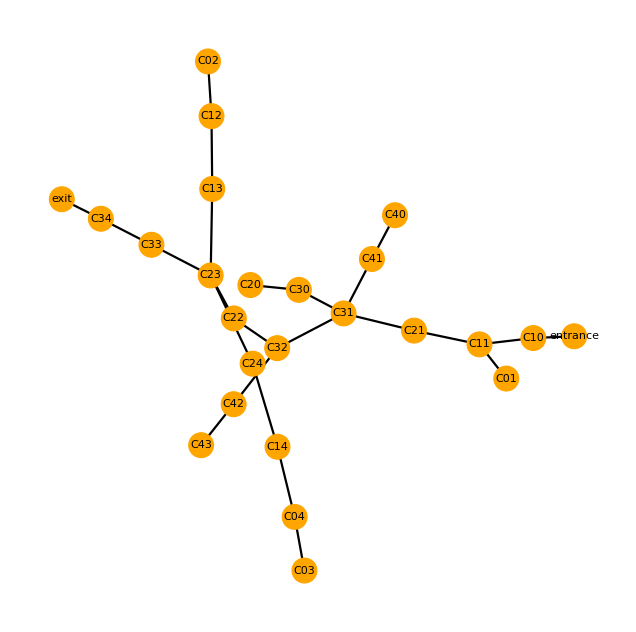

In [3]:
import json

def load_graph_from_file(filename):
  with open(filename) as labyrinth_file:
    dict_labyrinth = json.load(labyrinth_file)
    return nx.Graph(dict_labyrinth)

small_labyrinth = load_graph_from_file(pwd + "small_labyrinth.json")
large_labyrinth = load_graph_from_file(pwd + "large_labyrinth.json")
show_weighted_graph(small_labyrinth, 500, 10, (10,10))

The cells named `entrance` and `exit` are self-explanatory and are respectively equivalent to `C00` and `C44`. All the other cells are named `CXY` where `X` corresponds to the row and `Y` column of the cell in the image.


*NOTE: In this simple exercise, the arguably more difficult part is already done for us, which is to abstract the original problem (finding an exit path in a labyrinth) and cast is as a tree/graph search problem. This might not be the case in your coursework/exams, so take a moment to ponder about how this abstraction worked, and if you could have done it yourself.*

### 1.2. Depth First Search (DFS)

**Q. By filling the gaps below, write two python functions (a non-recursive and a recursive one) each returning a solution: a list of nodes composing the path found by DFS from the starting node to the node representing the goal state (including both). Alternatively, you can also return a list composing the edges that represent a solution path. Add the functionality to reverse the order of the explored nodes at each level.**

*Hint: In your code, you can take advantage of the method `<graph>.neighbors(<node_name>)` to find which nodes are connected to another.*

### DFS - Non-recursive

In [4]:
def iterativeDFS(graph, initial, goal):
    nExploredNodes = 1
    """
    NOTE ON nExploredNodes:
    "nExploredNodes" is just for statistical purposes, not relevant to the
    function. It is initialised as 1 since we count the 1st node already.
    """
    #====================================
    # Checking if we are already at the goal
    if initial == goal:
        return [initial], 0

    # If we are not at the goal, let's move on
    next_node = {"label":initial, "parent":None} # The next node to be explored
    path = [{"label":initial, "parent":None}] # Keeps track of the path
    frontier = [] # Keeps track of the nodes to explore later
    explored = [initial] # Keepts track of the nodes already explored
    while True:
        #====================================
        # EXPANDING CURRENT NODE IF POSSIBLE
        # Generating the node's children
        parent = next_node["label"]
        # Adding only unexplored children (to avoid revisits upon reiteration)
        # NOTE: This is important as we may backtrack later to this node
        try: children = [child for child in list(graph.neighbors(parent)) if child not in explored]
        except: break
        """
        NOTE ON THE ABOVE TWO LINES:
        If exception is thrown here, that means the node with the given label
        does not exist in the graph. This would happen if the initial node was
        invalid.
        """
        #------------------------
        # Checking if deadend has been reached
        if children == []: # Deadend node reached; backtracking needed
            path.pop()
            try: next_node = path[-1]
            except: break
            """
            NOTES ON THE ABOVE THREE LINES...
            ------------------------
            NOTE 1: BACKTRACKING:
            If the current node being explored is a deadend, we must backtrack,
            as we must check whether the parent node is also a deadend.
            Now, the parent node has been explored previously.
            However, the frontier does not keep track of explored nodes.
            Also, the explored only keeps track of labels.
            Thus, we simply go to the previous node of the path.
            As this node has been explored, no statistics need to be updated.
            ------------------------
            NOTE 2: LOOP TERMINATION CONDITION:
            If the path is empty, this means we have just removed the initial
            node from the path (which was the path's first element).
            This means the intial node is itself a deadend.
            This means no path exists, thus we must terminate the loop.
            """
            continue # Onto next iteration; backtracking to the parent
        #------------------------
        # If deadend not reached, pushing to top (here, index -1) ... (1)
        for child in children:
            if child == goal: # If goal found
                path += [{"label":child, "parent":parent}]
                # For the path, we will only return the path node labels
                return [p["label"] for p in path], nExploredNodes
            frontier.append({"label":child, "parent":parent})
        #====================================
        # PREPARING FOR THE NEXT ITERATION (WHERE NO BACKTRACKING WAS NEEDED)
        next_node = frontier.pop() # Popping from top (here, index -1) ... (2)
        nExploredNodes += 1 # Updating the explored count statistic (for statistical purposes)
        explored.append(next_node["label"])
        path.append({"label":child, "parent":parent})
        #------------------------
        # NOTE: (1) and (2) ensure a LIFO queue system
    #====================================
    return [] # No path found

In [5]:
# Printing the obtained path
print(iterativeDFS(small_labyrinth, "entrance", "exit")[0])

['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']


In [6]:
# Checking number of nodes explored
print(iterativeDFS(small_labyrinth, "entrance", "exit")[1])

12


You can now call your function with `small_labyrinth` (the example graph object we constructed before, representing our small labyrinth), `"entrance"` and `"exit"` as test arguments. Print the output list, and check if it should return `["entrance", "C10", "C11", "C21", "C31", "C32", "C22", "C23", "C33", "C34", "exit"]`.

### DFS - Recursive

In [7]:
def recursiveDFS(graph, initial, goal, explored = [], path = [], nExploredNodes = 0):
    # NOTE: "nExploredNodes" is just for statistical purposes, not relevant to the functions
    if nExploredNodes == 0: explored, path = [initial], []
    #------------------------
    # If I reach destination, I finish right here, return list with the final place
    if initial == goal:
        path.insert(0, initial)
        return initial, nExploredNodes
    # Marking the current node as explored (as we will definitely be exploring it now)
    explored.append(initial)
    nExploredNodes += 1
    #------------------------
    # Looping through the children & calling recursiveDFS for unexplored children
    for child in list(graph.neighbors(initial)):
        if child not in explored:
            # Checking if the goal has been found
            r = recursiveDFS(graph, child, goal, explored, path, nExploredNodes)
            if r != []:
                path.insert(0, initial) # Updating path, putting parents before children
                # NOTE: As we work backwards & thus know the call chain leading to the goal, we can get the path reliably
                return path, r[1] # r[1] holds the nExploredNodes statistic
    #------------------------
    # If no node works, I return empty string which would mean dead end
    return []

**IMPLEMENTATION NOTE**: When we pass arguments in function definitions with default values, we automatically make them optional arrguments. When you call the function without the optional argument, the default value is applied. However, if your default value is a default list, calling the function without the optional argument will lead to the argument defaulting to that particular list (even if you defined it as empty). A list's identifier does not denote primarily a value but a memory address; it is a pointer. Thus, defaulting to a default list value will bring back that created list (surprisingly, even if we initialize it in the definition as an empty list). As a result, repeated calls of the above function without the optional argument `explored` resulted in all the explored nodes of the previous call being retained (thus making the function return an empty set), and repeated calls with `explored` passed as `[]` and without the optional argument `path` resulted in the addition of new values to the path generated in the previous call.<br><br>To solve this, you can either pass these optional arguments as `[]` each during call, or you can add a condition at the start as follows (as I have done):

```
if nExploredNodes == 0: explored, path = [initial], []
```

This works because unlike a list, a primitive data type like an integer or floating point number refers to a value and not a memory location, so the default value `nExploredNodes` will reliably be initialized as 0 by default.

In [8]:
# Printing the path obtained
print(recursiveDFS(small_labyrinth, "entrance", "exit")[0])

['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']


In [9]:
# Checking number of nodes explored
print(recursiveDFS(small_labyrinth, "entrance", "exit")[1])

10


### 1.3. Breadth First Search (BFS)


**Q. By filling the gaps below, write two functions (an implementation with a queue and an implementation with a list) taking the same inputs as before but returning the list containing the nodes that represent the path found by BFS.**

### BFS with a Queue

**NOTE ON USING "EXPLORED" LISTS IN BFS**:<br>
In BFS, there is no danger of infinite loops, since we never backtrack here. Also, BFS satisfies completeness, meaning it will always find a solution (in theory, given enough time and memory). Thus, we do not need an "explored" list as in DFS. However, when dealing with graphs, we can only check for neighbors, and these neighbors can include a parent node in the context of tree search. In other words, when we check for a child node's own children in our search, generating its children by generating its neighbors will cause this child's parent node to also be generated as a child. This could lead to redundant loopy paths within the search. However, because BFS is complete unlike DFS, there is no danger of creating an infinite loop and we are guaranteed a solution in theory; the only constraints are memory and time. Thus, to improve on these constraints, we can use an "explored" list in BFS also, which will act as a way to prevent looping paths from generating. Furthermore, if the graph has a lot of interconnections, not keeping a track of visited nodes can lead to multiple paths traversing the same nodes, which is a waste of time and memory. Moreover, I will be using the "explored" lists so as to get accurate statistics about nodes visited in a properly constructed, i.e. non-looping BFS implementation.
<br><br>
**SIDE NOTE**: I tried this BFS algorithms without the "explored" list, and it worked correctly (_unlike when I tried the same for the DFS algorithms, which entered infinite loops within the first few steps_). However, the amount of nodes explored was vastly greater (compare ~730 without "explored" list to 21 with the "explored" list).
    

In [10]:
def queueBFS(graph, initial, goal):
    nExploredNodes = 0
    """
    NOTE ON nExploredNodes:
    "nExploredNodes" is just for statistical purposes, not relevant to the
    function. It is initialised as 1 since we count the 1st node already.
    """
    #====================================
    # Checking if we are already at the goal
    if initial == goal:
        return [initial], 0

    # If we are not at the goal, let's move on
    frontier = [{"label":initial, "parent":None}] # Keeps track of the nodes to explore later
    explored = [] # Keepts track of the explored nodes
    """
    NOTE ON THE "ancestors" LIST:
    It so to prevent generation of looping paths leading from child to parent.
    """

    while frontier != []:
        #====================================
        # PREPARING FOR THE NEXT ITERATION (WHERE NO BACKTRACKING WAS NEEDED)
        next_node = frontier.pop() # Popping from front (here, index -1) ... (2)
        nExploredNodes += 1 # Updating the explored count statistic (for statistical purposes)
        explored.append(next_node["label"])
        #====================================
        # EXPANDING CURRENT NODE IF POSSIBLE
        # Generating the node's children
        parent = next_node["label"]
        # Adding only unexplored children (to avoid revisits upon reiteration)
        # NOTE: This is important as we may backtrack later to this node
        try: children = [child for child in list(graph.neighbors(parent)) if child not in explored]
        except: break
        """
        NOTE ON THE ABOVE TWO LINES:
        If exception is thrown here, that means the node with the given label
        does not exist in the graph. This would happen if the initial node was
        invalid.
        """
        #------------------------
        # Checking if deadend has been reached
        if children != []:
          # If deadend not reached, pushing to rear (here, index 0) ... (1)
          for child in children:
              if child == goal: # If goal found
                  # For the path, we will only return the path node labels
                  return {"label": child, "parent": parent}, nExploredNodes
              frontier.insert(0, {"label":child, "parent":parent})
        #------------------------
        # NOTE: (1) and (2) ensure a FIFO queue system
    #====================================
    return [] # No path found

In [11]:
# A helper function to construct the path
def queueBFSPath(graph, initial, goal):
    try: cur, nExploredNodes = queueBFS(graph, initial, goal)
    except: return []
    cur, path = cur["parent"], [goal]
    while cur != initial:
        path.insert(0, cur)
        cur = queueBFS(graph, initial, cur)[0]["parent"]
    return [initial] + path, nExploredNodes

**IMPLEMENTATION NOTE**: **Need for** `queueBFSPath` **helper function**:<br>We cannot construct a path in BFS as we go because of the way new nodes are added. This is because we add every node of a level, then the next, etc. rather than check one path at a time, as in DFS.

Calling your new function with the same input as before, (`small_labyrinth`, `"entrance"` and `"exit"`) you should find exactly the same output: `["entrance", "C10", "C11", "C21", "C31", "C32", "C22", "C23", "C33", "C34", "exit"]`


In [12]:
# Printing the path obtained
print(queueBFSPath(small_labyrinth, "entrance", "exit"))

(['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit'], 21)


In [13]:
# Checking number of nodes explored
print(queueBFS(small_labyrinth, "entrance", "exit")[1])

21


### BFS with a Search Tree

In this implementation of BFS, we will generate a search tree in the form of a list of paths. Here are key points for this implementation:

- The tree is a list of lists, wherein each sublist is a path
- Adding a child to an existing path creates a new path<br>
  - _Thus, adding_ $n$ _children creates_ $n$ _new paths_
- Always fork from the tail (i.e. last added node) of the path
  - Generate new forks (children) from the tail
  - Combine forks with previous path to create new paths
- Each path is ordered as in a tree hierarchy
  - The $k$th node of a path is the descendant of nodes $1, 2 ... k-1$
  - Thus, an "ancestors" list to preserve ancestors is not needed
  - However, in case the graph has many interconnections, to avoid redundant traversals (where two or more paths traverse the same nodes), it is useful to store & refer to a list of visited nodes (i.e. the nodes placed in paths)
  - This is relevant here more than in the queue-version of the BFS because we are storing whole paths along with the final node which is either unexplored or a deadend, whereas in the queue-version, we were keeping the children aside to explore & add to the path later rather than add the unexplored child to the path right away
  - This is why here, we talk about "visited" nodes rather than "explored" nodes; we are indeed including all visited nodes & not just explored ones
- If the goal is found, we can simply return:
    - **_current path being expanded_** + **_goal_**
- Preserve deadends separately for later presentation

In [14]:
def searchTreeBFS(graph, initial, goal, showPaths = False):
    nExploredNodes = 0
    # NOTE: "nExploredNodes" is just for statistical purposes, not relevant to the functions
    #------------------------
    # List of existent paths (for now only initial)
    curPaths = [[initial]]
    visited = []
    deadends = [] # To preserve deadends
    while True:
        newPaths = []
        for i, path in enumerate(curPaths):
            # NOTE: i helps keep track of how much of the current paths have been covered
            # (enumeration starts with 0, matching the indexing)
            #------------------------
            # Generating children for the tail (i.e. the last node added to the path)
            children = [child for child in graph.neighbors(path[-1]) if child not in visited]
            """
            IMPLEMENTATION NOTE:
            In queueBFS, we used an "explored" list to avoid generating paths looping back to parent nodes.
            However, here, all the ancestor nodes of the would be children are within the list "path".
            But, we may still traverse through nodes in other generated paths.
            Thus, we still use an "explored" list.
            """
            nExploredNodes +=1 # Since we have just explored a node by generating its children

            if children == []: # Deadend reached; continue to next iteration
                deadends.append(path)
                """
                NOTE ON THE ABOVE LINE:
                This is to preserve this path for presentation, as it will not be added to newPaths
                & will thus be removed from curPaths after this loop terminates.
                """
                continue

            # Generating all forks from this point
            for child in children:
                # If the goal is found, add it to the parent path & return the new path
                if child == goal:
                    if showPaths:
                        # Collecting all the generated paths (including preserved deadends & the winning path)
                        curPaths = deadends + newPaths + curPaths[i+1:] + [path + [child]]
                        return path + [child], nExploredNodes, curPaths
                    else: return path + [child],  nExploredNodes
                    """
                    IMPLEMENTATION NOTE:
                    newPaths has expanded paths of curPaths only until index i.
                    This, to include all paths generated thus far but also to not repeat trodden paths,
                    we add all paths of newPaths to all paths of curPaths after index i.
                    """
                visited.append(child)
                newPaths.append(path + [child])
                """
                COMMENT ON THE ABOVE LINE:
                Here, we generate the fork [path[-1], child].
                Then, we create a new path from the existing path "path".
                """
        if newPaths == []: break # If all end nodes are deadends
        else: curPaths = newPaths

    if showPaths:
        # Collecting all the generated paths (including preserved deadends)
        curPaths = deadends + newPaths + curPaths[i+1:]
        return [], nExploredNodes, curPaths
    else: return [], nExploredNodes

In [15]:
# Printing the path obtained
print(searchTreeBFS(small_labyrinth, "entrance", "exit", False)[0])

['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']


In [16]:
# Checking number of nodes explored
print(searchTreeBFS(small_labyrinth, "entrance", "exit", False)[1])

21


In [17]:
# Displaying all paths generated during search
genPaths = searchTreeBFS(small_labyrinth, "entrance", "exit", True)[2]
for i, path in enumerate(genPaths): print(f"Path {i}:\n{path}")

Path 0:
['entrance', 'C10', 'C11', 'C01']
Path 1:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C30', 'C20']
Path 2:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C41', 'C40']
Path 3:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C42', 'C43']
Path 4:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C13', 'C12', 'C02']
Path 5:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C24', 'C14', 'C04']
Path 6:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']


### 1.4. A bit of analysis

You might wonder why we should implement both BFS and DFS if they output exactly the same path at the end. If it's not already clear, let's investigate a bit more:

**Q. Modify your code so that it also returns the number of nodes visited along with the solution path. Then run the analysis below.**

In [18]:
def results(variationNumber, graph, initial, goal):
    # Variation 1 ==> Iterative methods
    # Variation 2 ==> Recursive (for DFS) & search tree method (for BFS)

    print(f"RESULTS FOR VARIATION {variationNumber}\n------------------------")

    # VARIATION 1
    if str(variationNumber) == "1":
        BFS = queueBFSPath(graph, initial, goal)
        DFS = iterativeDFS(graph, initial, goal)
    # VARIATION 2
    elif str(variationNumber) == "2":
        BFS = searchTreeBFS(graph, initial, goal)
        DFS = recursiveDFS(graph, initial, goal)

    # The results
    print("Nodes explored...")
    print("BFS:", BFS[1])
    print("DFS:", DFS[1])
    print("\nPaths...")
    print(f"BFS:\n{BFS[0]}")
    print(f"DFS:\n{DFS[0]}")

###  BFS and DFS - Variation 1

In [19]:
results(1, small_labyrinth, "entrance", "exit")

RESULTS FOR VARIATION 1
------------------------
Nodes explored...
BFS: 21
DFS: 12

Paths...
BFS:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']
DFS:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']


### BFS and DFS - Variation 2

In [20]:
results(2, small_labyrinth, "entrance", "exit")

RESULTS FOR VARIATION 2
------------------------
Nodes explored...
BFS: 21
DFS: 10

Paths...
BFS:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']
DFS:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']


Now, for DFS, let's change the way you pick the next node. For instance, if the neighbours of a node are `[a, b, c]`, instead of visiting `a` first, let's visit `c` first.

### BFS and DFS - Variation 1

In [21]:
results(1, small_labyrinth, "exit", "entrance")

RESULTS FOR VARIATION 1
------------------------
Nodes explored...
BFS: 23
DFS: 22

Paths...
BFS:
['exit', 'C34', 'C33', 'C23', 'C22', 'C32', 'C31', 'C21', 'C11', 'C10', 'entrance']
DFS:
['exit', 'C34', 'C33', 'C23', 'C22', 'C32', 'C31', 'C21', 'C11', 'C10', 'entrance']


### BFS and DFS - Variation 2

In [22]:
results(2, small_labyrinth, "exit", "entrance")

RESULTS FOR VARIATION 2
------------------------
Nodes explored...
BFS: 23
DFS: 10

Paths...
BFS:
['exit', 'C34', 'C33', 'C23', 'C22', 'C32', 'C31', 'C21', 'C11', 'C10', 'entrance']
DFS:
['exit', 'C34', 'C33', 'C23', 'C22', 'C32', 'C31', 'C21', 'C11', 'C10', 'entrance']


If everything works well, the path returned should be exactly the same. But what about the number of cells you have visited? Can you do the same thing with BFS? Explain why.

### 1.5. BFS or DFS?


The last subsection showed that how we choose to explore in DFS will impact the efficiency of the search. So why not just using BFS then? Let's try to understand why.


Let's consider a larger labyrinth. Use your two search functions that you implemented in order to find a path between `"entrance"` and `"exit"`. The graph you are going to work with corresponds to the following labyrinth:

![Image: a larger labyrinth example.](https://drive.google.com/uc?id=14KFgxnoM4P5UFSkb7Hth30YBR7QPAcRx)




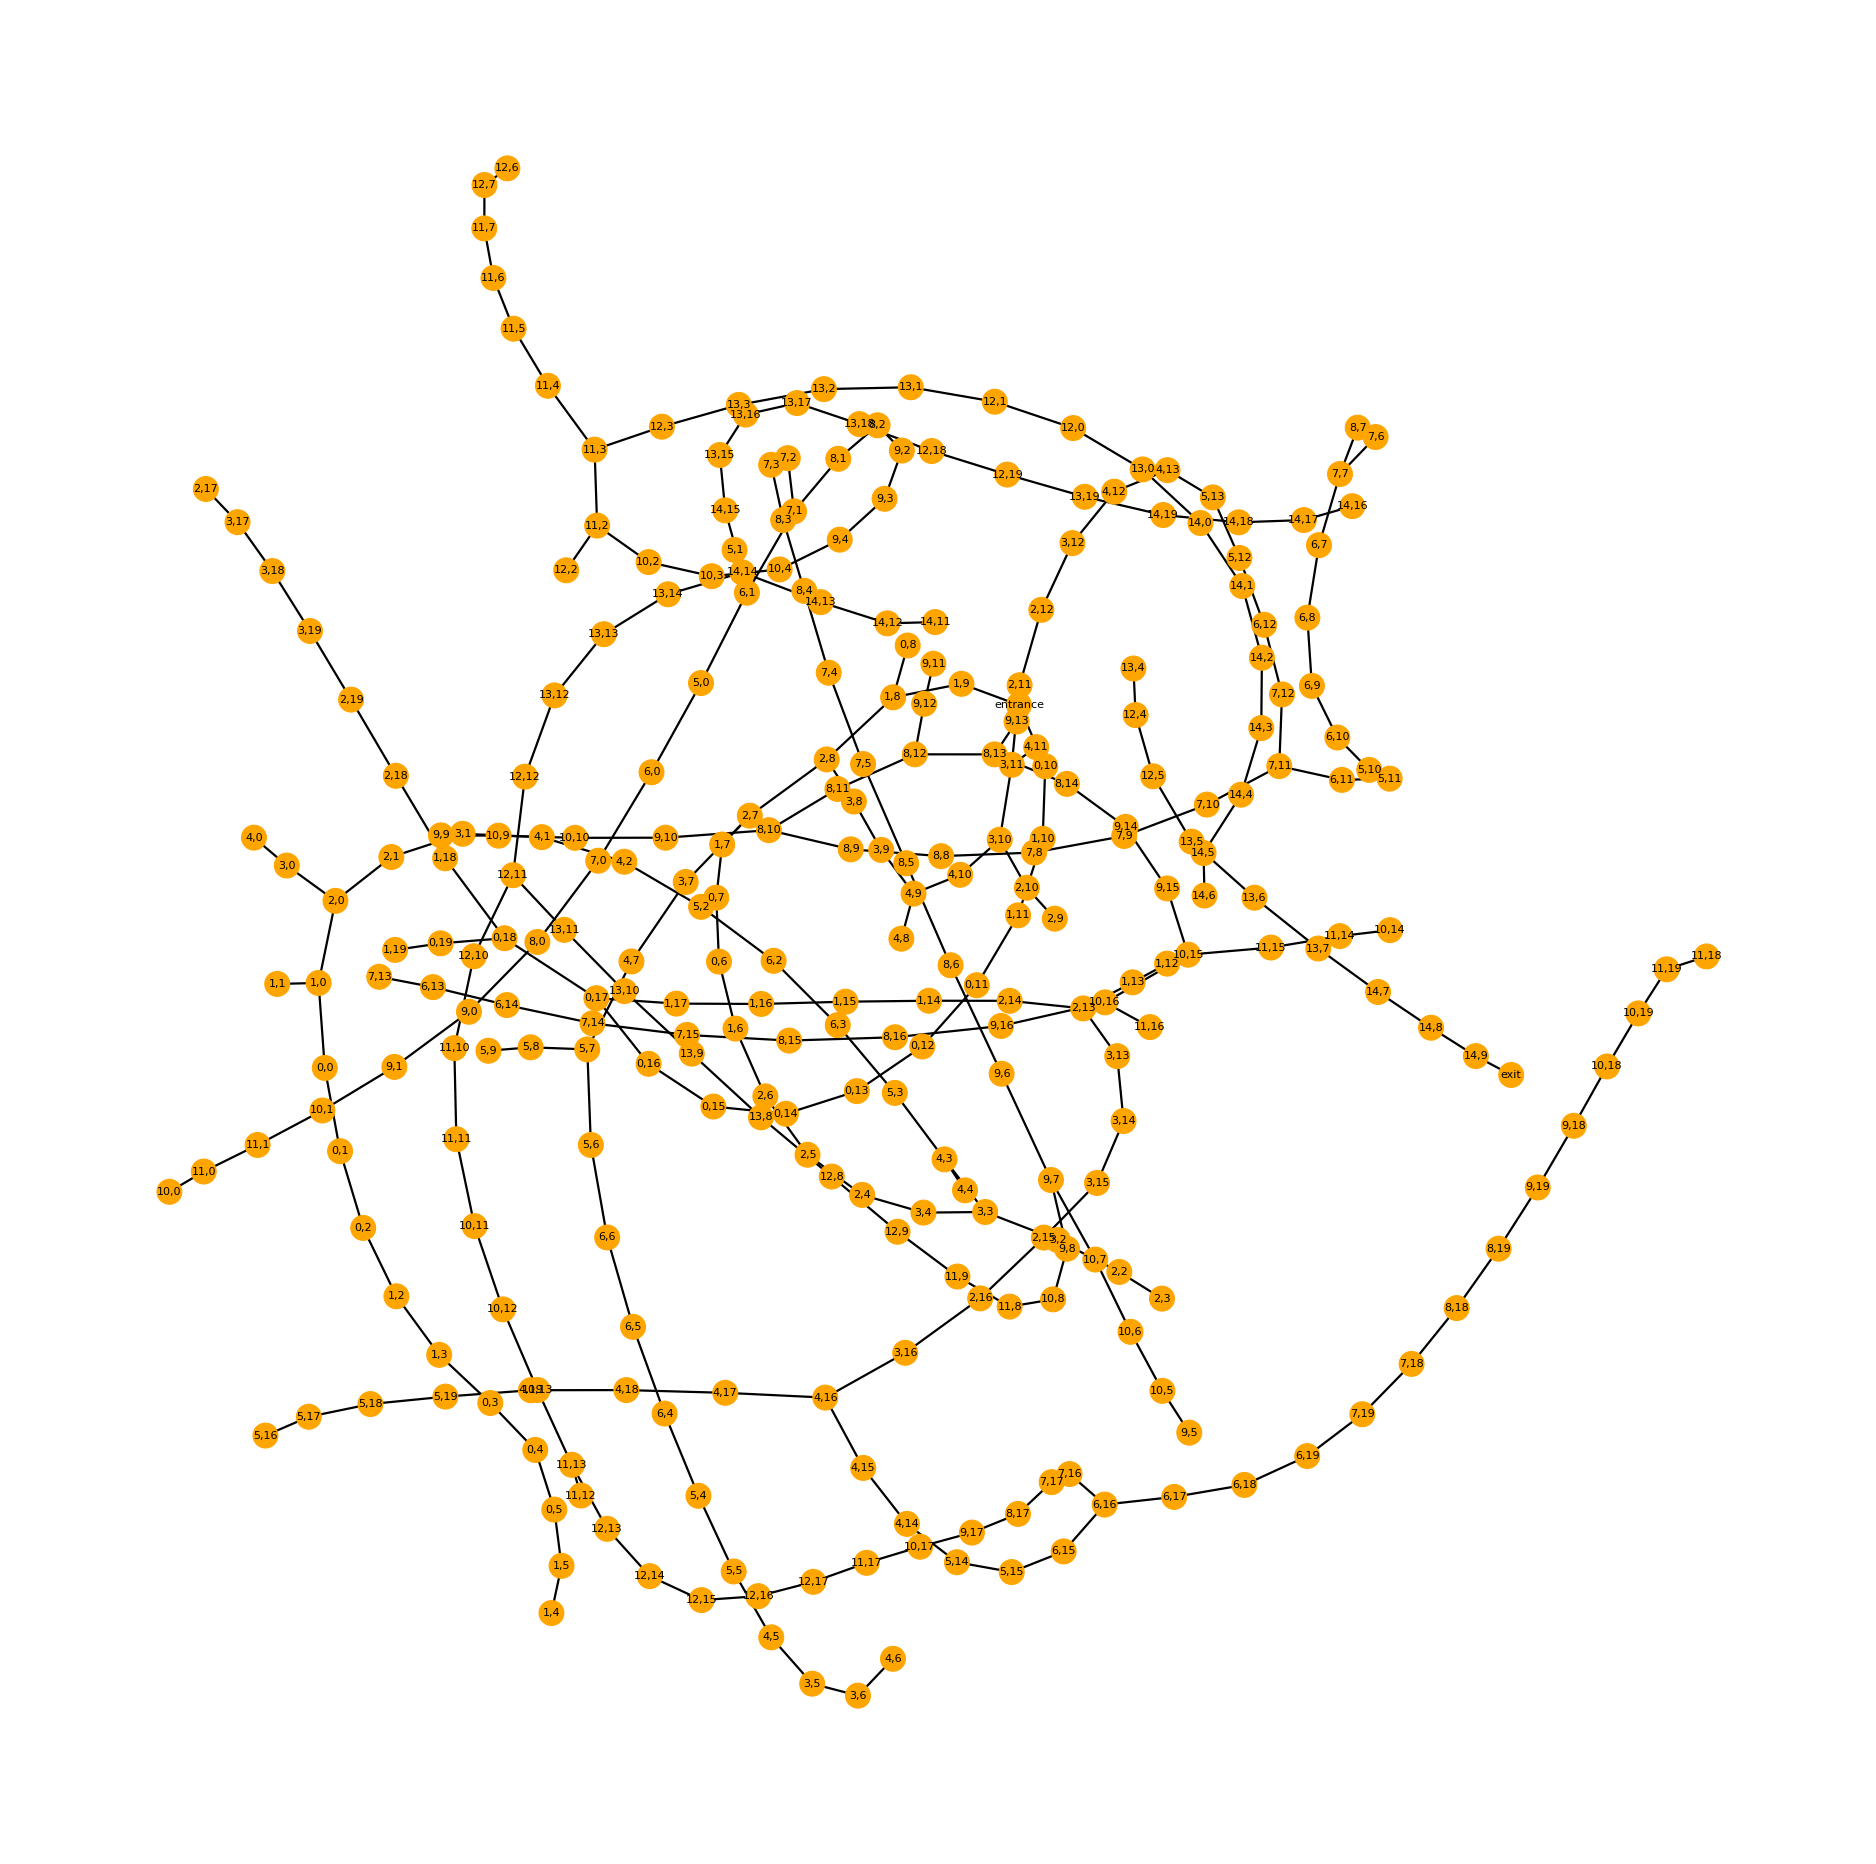

In [23]:
large_labyrinth = load_graph_from_file(pwd + "large_labyrinth.json")
show_weighted_graph(large_labyrinth, 500, 10, (30, 30))

### Variation 1

In [24]:
results(1, small_labyrinth, "entrance", "exit")

RESULTS FOR VARIATION 1
------------------------
Nodes explored...
BFS: 21
DFS: 12

Paths...
BFS:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']
DFS:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']


### Variation 2

In [25]:
results(2, small_labyrinth, "entrance", "exit")

RESULTS FOR VARIATION 2
------------------------
Nodes explored...
BFS: 21
DFS: 10

Paths...
BFS:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']
DFS:
['entrance', 'C10', 'C11', 'C21', 'C31', 'C32', 'C22', 'C23', 'C33', 'C34', 'exit']


By the way, both of your algorithms should output a list corresponding to the following solution:

![alt text](https://drive.google.com/uc?id=1qTM-WlnWaUJNELzwgfpgR6qVuk-KrW9S)

Note that in both scenarios, DFS visits less states. The difference is even more obvious with big labyrinth with a lot of walls. On one hand, BFS ensures you to get the optimal solution on non weighted graph and is less efficient on trees with an important branching factor. On the other hand, DFS is more efficient of such problems but might explore more solutions than BFS if the graph is very deep.

# 2. Limits of BFS and DFS


In the previous examples, except for the number of nodes visited before finding the solution path, we cannot intuitively evaluate whether the solution path is good or bad since there exists only one path (the solution is unique).

In some other problems, just finding a solution path is not enough or interesting, and we rather want to find the best possible solution (the one with the lowest cost).

For instance, let's say for travelling from city A to city B, most of the travellers would prefer taking the shortest path. Let's see if BFS and DFS can help in such scenarios.

In [26]:
uk_cities = load_graph_from_file(pwd + "UK_cities.json")
show_weighted_graph(uk_cities, 2500, 10, (50, 50))

Output hidden; open in https://colab.research.google.com to view.

Run both your DFS and BFS on this graph in order to find a path between London and Aberdeen. The arguments should be `"uk_cities", "london"` and `"aberdeen"`.



### Variation 1

In [27]:
results(1, uk_cities, "london", "aberdeen")

RESULTS FOR VARIATION 1
------------------------
Nodes explored...
BFS: 20
DFS: 3

Paths...
BFS:
['london', 'birmingham', 'portsmouth', 'aberdeen']
DFS:
['london', 'oxford', 'york', 'aberdeen']


### Variation 2

In [28]:
results(2, uk_cities, "london", "aberdeen")

RESULTS FOR VARIATION 2
------------------------
Nodes explored...
BFS: 20
DFS: 4

Paths...
BFS:
['london', 'birmingham', 'portsmouth', 'aberdeen']
DFS:
['london', 'birmingham', 'brighton', 'aberystwyth', 'aberdeen']


**Q. By filling the gaps below, compute the cost of the path found by each algorithm. Can you guarantee that you have the shortest path? Explain why.**

In [29]:
def compute_path_cost(graph, path):
    cost, max = 0, len(path)
    for i in range(max-1):
        cost += uk_cities.edges[(path[i], path[i+1])]["weight"]
    return cost

### Variation 1

For this implementation, we only have two generated paths.

In [30]:
path1 = queueBFSPath(uk_cities, "london", "aberdeen")[0]
path2 = iterativeDFS(uk_cities, "london", "aberdeen")[0]

path1_cost = compute_path_cost(uk_cities, path1)
path2_cost = compute_path_cost(uk_cities, path2)

print("Cost for path {}: {}".format(path1, path1_cost))
print("Cost for path {}: {}".format(path2, path2_cost))

Cost for path ['london', 'birmingham', 'portsmouth', 'aberdeen']: 801
Cost for path ['london', 'oxford', 'york', 'aberdeen']: 534


###  Variation 2

In [31]:
path1 = searchTreeBFS(uk_cities, "london", "aberdeen")[0]
path2 = recursiveDFS(uk_cities, "london", "aberdeen")[0]

path1_cost = compute_path_cost(uk_cities, path1)
path2_cost = compute_path_cost(uk_cities, path2)

print("Cost for path {}: {}".format(path1, path1_cost))
print("Cost for path {}: {}".format(path2, path2_cost))

Cost for path ['london', 'birmingham', 'portsmouth', 'aberdeen']: 801
Cost for path ['london', 'birmingham', 'brighton', 'aberystwyth', 'aberdeen']: 945
